In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from imblearn.over_sampling import SMOTE

In [2]:
def calculate_vpd(temperature, humidity):
    """Calculate Vapor Pressure Deficit (VPD) given temperature (°C) and relative humidity (%)."""
    es = 0.6108 * np.exp((17.27 * temperature) / (temperature + 237.3))  # Saturation vapor pressure in kPa
    ea = es * (humidity / 100.0)  # Actual vapor pressure in kPa
    vpd = es - ea  # VPD in kPa
    return vpd

def get_part_of_day(hour):
    """Phân loại giờ trong ngày thành các buổi có ý nghĩa nông nghiệp."""
    if 5 <= hour <= 10: return 'Morning'
    if 11 <= hour <= 15: return 'Midday'  # Giai đoạn nắng gắt, nhu cầu nước cao nhất
    if 16 <= hour <= 19: return 'Afternoon'
    return 'Night' # Ban đêm, nhu cầu nước thấp

In [3]:
#---- Load datasets ----#


climate_df = pd.read_csv('GreenhouseClimate.csv', low_memory=False)
weather_df = pd.read_csv('Weather.csv', low_memory=False)
grodan_df = pd.read_csv('GrodanSens.csv', low_memory=False)

#------ Data frame merged ----#

merged_df = pd.merge(climate_df, weather_df, on='%time', how='inner')
full_df = pd.merge(merged_df, grodan_df, on='%time', how='inner')

print("Hợp nhất thành công!")
print(f"  - Bộ dữ liệu tổng hợp có {full_df.shape[0]} dòng và {full_df.shape[1]} cột.")

Hợp nhất thành công!
  - Bộ dữ liệu tổng hợp có 47809 dòng và 66 cột.


In [4]:
print("\nBắt đầu làm sạch và chuẩn hóa...")
# 3.1. Chuyển đổi cột '%time' sang định dạng datetime chuẩn
# Định dạng thời gian trong Excel là số ngày kể từ mốc '1899-12-30'
full_df['datetime'] = pd.to_datetime(full_df['%time'], unit='D', origin='1899-12-30')

full_df.set_index('datetime', inplace=True)
full_df.drop('%time', axis=1, inplace=True) # Bỏ cột '%time' cũ

print(" - Đã chuyển đổi và đặt cột thời gian làm index.")



Bắt đầu làm sạch và chuẩn hóa...
 - Đã chuyển đổi và đặt cột thời gian làm index.


In [5]:
env_features = [
    # Từ GreenhouseClimate
    'Tair', 'Rhair', 'CO2air', 'HumDef', 'PipeGrow', 'PipeLow', 'Tot_PAR',
    # Từ Weather
    'Tout', 'Rhout', 'Iglob', 'Windsp', 'RadSum', 'Rain', 'PARout', 'Pyrgeo', 'AbsHumOut',
    # Từ GrodanSens
    'EC_slab1', 'EC_slab2', 'WC_slab1', 'WC_slab2', 't_slab1', 't_slab2',
    # Cột target
    'Cum_irr'
]
print(f"  - Giữ lại {len(env_features)} cột môi trường và cột target.")
clean_df = full_df[env_features].copy()


  - Giữ lại 23 cột môi trường và cột target.


In [6]:
for col in clean_df.columns:
    clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')

print("  - Chuyển đổi sang kiểu số hoàn tất.")

  - Chuyển đổi sang kiểu số hoàn tất.


In [7]:
#-------------------------------------------------------------
#----- Nan processing ----#
print(f"  - Số dòng TRƯỚC khi loại bỏ NaN: {len(clean_df)}")
clean_df.dropna(subset=env_features[:-1], inplace=True) 
print(f"  - Số dòng SAU khi loại bỏ NaN: {len(clean_df)}")

  - Số dòng TRƯỚC khi loại bỏ NaN: 47809
  - Số dòng SAU khi loại bỏ NaN: 45460


In [8]:
#----- Data feature engineering (OPTIMIZED FOR 30-MIN WAKE-UP) ----#

# 1. Create time-based features
clean_df['VPD'] = calculate_vpd(clean_df['Tair'], clean_df['Rhair'])
clean_df['hour'] = clean_df.index.hour
clean_df['dayofweek'] = clean_df.index.dayofweek

# 2. Create Rolling/Lag Features based on 30-MINUTE WINDOW ONLY
WINDOW_SIZE_30M = 6  # 30 minutes (5 min intervals * 6)

# Calculate Average/Sum over the 30-minute wake-up period
clean_df['Tair_30m_avg'] = clean_df['Tair'].rolling(window=WINDOW_SIZE_30M).mean()
clean_df['Iglob_30m_sum'] = clean_df['Iglob'].rolling(window=WINDOW_SIZE_30M).sum()

# Calculate the change from the start of wake-up to decision time
clean_df['WC_slab1_30m_ago'] = clean_df['WC_slab1'].shift(WINDOW_SIZE_30M)
clean_df['Tair_30m_diff'] = clean_df['Tair'].diff(WINDOW_SIZE_30M)

# 3. Interactions
clean_df['PAR_x_HumDef'] = clean_df['Tot_PAR'] * clean_df['HumDef']
clean_df['Tair_x_Iglob'] = clean_df['Tair'] * clean_df['Iglob']

# 4. Part of Day Encoding
clean_df['PartOfDay'] = clean_df['hour'].apply(get_part_of_day)
part_of_day_dummies = pd.get_dummies(clean_df['PartOfDay'], prefix='PartOfDay')
clean_df = pd.concat([clean_df, part_of_day_dummies], axis=1)
clean_df.drop(['PartOfDay', 'hour'], axis=1, inplace=True)

print(" - Feature Engineering complete (Restricted to 30-min history).")

# 5. Drop NaN values created by the 30-min lag
print(f" - Số dòng TRƯỚC khi bỏ NaN: {len(clean_df)}")
clean_df.dropna(inplace=True)
print(f" - Số dòng SAU khi bỏ NaN: {len(clean_df)}")

 - Feature Engineering complete (Restricted to 30-min history).
 - Số dòng TRƯỚC khi bỏ NaN: 45460
 - Số dòng SAU khi bỏ NaN: 45454


In [9]:
# =============================================================================
# BƯỚC 5: XÁC ĐỊNH BIẾN MỤC TIÊU VÀ RESAMPLE (3-HOUR CYCLE)
# =============================================================================

# 1. Dọn dẹp và nội suy cột Cumulative Irrigation
clean_df['Cum_irr'] = pd.to_numeric(clean_df['Cum_irr'], errors='coerce')
clean_df['Cum_irr'].interpolate(method='time', inplace=True)
clean_df['Cum_irr'].fillna(method='ffill', inplace=True)

# 2. TÍNH TOÁN LƯỢNG NƯỚC THỰC TẾ (5-min interval)
raw_water_diff = clean_df['Cum_irr'].diff()

# Giữ lại giá trị dương, đặt âm thành 0
clean_df['Watering_Amount'] = np.where(raw_water_diff > 0, raw_water_diff, 0)

# Xóa cột cũ không cần thiết
clean_df.drop('Cum_irr', axis=1, inplace=True)
clean_df = clean_df.iloc[1:].copy() 

print("\n--- ĐANG CHUYỂN ĐỔI SANG CHU KỲ 3 GIỜ (RESAMPLING) ---")

# 3. ĐỊNH NGHĨA CÁCH GỘP DỮ LIỆU
# - Target ('Watering_Amount'): Cộng tổng lượng nước trong 3 giờ.
# - Features (Tair, VPD, etc.): Lấy giá trị CUỐI CÙNG (Last) của chu kỳ.
#   (Vì giá trị cuối cùng chứa 'Tair_30m_avg' - tức là trung bình 30p lúc máy thức)

conversion_dict = {
    'Watering_Amount': 'sum'
}

# Tất cả các cột còn lại (features) sẽ dùng 'last'
input_features = [c for c in clean_df.columns if c != 'Watering_Amount']
for col in input_features:
    conversion_dict[col] = 'last'

# 4. THỰC HIỆN RESAMPLE
df_3h = clean_df.resample('3H').agg(conversion_dict)

# Loại bỏ các dòng bị NaN sau khi gộp (nếu có)
df_3h.dropna(inplace=True)

print(f"✅ Đã chuyển đổi xong!")
print(f" - Dữ liệu gốc (5 phút): {clean_df.shape}")
print(f" - Dữ liệu mới (3 giờ):   {df_3h.shape}")

print("\nPhân bố của biến mục tiêu (3-Hour Regression):")
print(df_3h['Watering_Amount'].describe()) 



--- ĐANG CHUYỂN ĐỔI SANG CHU KỲ 3 GIỜ (RESAMPLING) ---
✅ Đã chuyển đổi xong!
 - Dữ liệu gốc (5 phút): (45453, 35)
 - Dữ liệu mới (3 giờ):   (1273, 35)

Phân bố của biến mục tiêu (3-Hour Regression):
count    1273.000000
mean        0.555852
std         0.757841
min         0.000000
25%         0.000000
50%         0.300000
75%         0.800000
max         5.400000
Name: Watering_Amount, dtype: float64


/tmp/ipykernel_596470/350044307.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_df['Cum_irr'].interpolate(method='time', inplace=True)
/tmp/ipykernel_596470/350044307.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [10]:
print(df_3h.head())
print(f"\nKích thước cuối cùng: {df_3h.shape}")

new_cols_to_check = ['PartOfDay_Midday', 'PartOfDay_Night', 'Tair_30m_diff']

valid_cols = [c for c in new_cols_to_check if c in df_3h.columns]
print(df_3h[valid_cols].head())

df_3h.to_csv('processed_greenhouse_data_clean.csv')
print("\nĐã lưu vào file 'processed_greenhouse_data_clean.csv'")


                     Watering_Amount  Tair  Rhair  CO2air  HumDef  PipeGrow  \
datetime                                                                      
2019-12-17 09:00:00              0.0  21.6   70.1   818.0     5.7       0.0   
2019-12-17 12:00:00              0.0  21.4   70.6   669.0     5.5       0.0   
2019-12-17 15:00:00              0.0  20.9   69.3   592.0     5.6       0.0   
2019-12-17 18:00:00              0.0  13.2   76.5   435.0     2.7       0.0   
2019-12-17 21:00:00              0.0  12.8   81.2   471.0     2.1       0.0   

                     PipeLow  Tot_PAR  Tout  Rhout  ...  Tair_30m_avg  \
datetime                                            ...                 
2019-12-17 09:00:00     39.4    126.0  12.0   80.9  ...     21.516667   
2019-12-17 12:00:00      0.0    126.0  13.7   75.6  ...     21.716667   
2019-12-17 15:00:00     41.3    149.0  10.4   95.4  ...     20.666667   
2019-12-17 18:00:00      0.0      0.0   7.5   99.5  ...     13.250000   
2019-12-

In [11]:
print("\n Bắt đầu chuẩn bị dữ liệu huấn luyện (Regression)...")

df_3h = pd.read_csv('processed_greenhouse_data_clean.csv', index_col='datetime', parse_dates=True)
print(f" - Kích thước bộ dữ liệu đã tải: {df_3h.shape}")

y = df_3h['Watering_Amount']
X = df_3h.drop('Watering_Amount', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"  - Kích thước tập Train: {X_train.shape}")
print(f"  - Kích thước tập Test: {X_test.shape}")
print(f"  - Ngày bắt đầu tập Train: {X_train.index.min()}")
print(f"  - Ngày kết thúc tập Train: {X_train.index.max()}")
print(f"  - Ngày bắt đầu tập Test:  {X_test.index.min()}")
print(f"  - Ngày kết thúc tập Test:  {X_test.index.max()}")


 Bắt đầu chuẩn bị dữ liệu huấn luyện (Regression)...
 - Kích thước bộ dữ liệu đã tải: (1273, 35)
  - Kích thước tập Train: (1018, 34)
  - Kích thước tập Test: (255, 34)
  - Ngày bắt đầu tập Train: 2019-12-17 09:00:00
  - Ngày kết thúc tập Train: 2020-04-24 06:00:00
  - Ngày bắt đầu tập Test:  2020-04-24 09:00:00
  - Ngày kết thúc tập Test:  2020-05-26 09:00:00


In [29]:
lgb_reg = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=100,         # Reduced from 700
    learning_rate=0.025,       # Increased slightly
    num_leaves=15,            # Simpler trees
    max_depth=5,              # Reduced from 20
    min_child_samples=10,     # Ensure leaves have enough data
    # --------------------------
    random_state=42,
    n_jobs=-1,
    reg_alpha=0.1,            # Reduced regularization slightly
    colsample_bytree=0.8
)

start_time = time.time()
lgb_reg.fit(X_train, y_train)
end_time = time.time()

print(f"\nTinh chỉnh hoàn tất trong {(end_time - start_time):.2f} giây.")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4809
[LightGBM] [Info] Number of data points in the train set: 1018, number of used features: 34
[LightGBM] [Info] Start training from score 0.490275

Tinh chỉnh hoàn tất trong 0.21 giây.



--- Đánh giá mô hình trên tập Test (Tương lai) ---
📉 RMSE (Sai số bình phương trung bình): 0.5710
📉 MAE (Sai số tuyệt đối trung bình):  0.3729
📊 R2 Score (Độ phù hợp): 0.6115

--- Kiểm tra an toàn (Classification Proxy) ---
🛡️ RECALL (Độ nhạy - Quan trọng nhất): 0.9805
🎯 PRECISION (Độ chính xác khi tưới):  0.7123


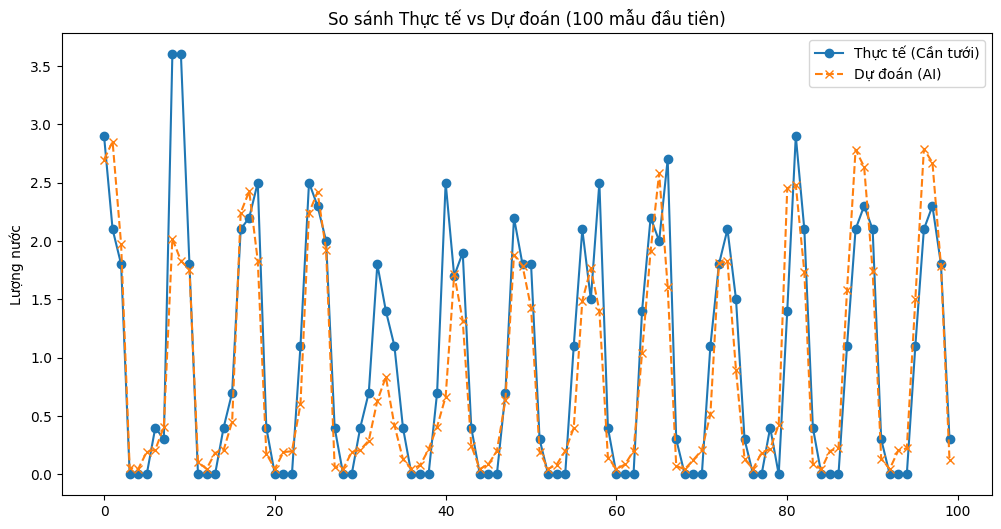

In [30]:
# Evaluate model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, recall_score

print("\n--- Đánh giá mô hình trên tập Test (Tương lai) ---")

# 1. Dự đoán
y_pred = lgb_reg.predict(X_test)

# 2. Ép các giá trị âm về 0 (Mô hình hồi quy đôi khi dự đoán -0.01)
y_pred = np.maximum(y_pred, 0)

# 3. Metrics Hồi quy (Độ chính xác về lượng nước)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE (Sai số bình phương trung bình): {rmse:.4f}")
print(f"📉 MAE (Sai số tuyệt đối trung bình):  {mae:.4f}")
print(f"📊 R2 Score (Độ phù hợp): {r2:.4f}")

# 4. CHECK RECALL (Kiểm tra an toàn)
# Nếu thực tế cần > 0.1 đơn vị nước, mà model dự đoán > 0.1, thì là ĐÚNG.
threshold = 0.1 

y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred > threshold).astype(int)

recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)

print(f"\n--- Kiểm tra an toàn (Classification Proxy) ---")
print(f"🛡️ RECALL (Độ nhạy - Quan trọng nhất): {recall:.4f}")
print(f"🎯 PRECISION (Độ chính xác khi tưới):  {precision:.4f}")

# 5. Vẽ biểu đồ so sánh
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Thực tế (Cần tưới)', marker='o')
plt.plot(y_pred[:100], label='Dự đoán (AI)', linestyle='--', marker='x')
plt.title("So sánh Thực tế vs Dự đoán (100 mẫu đầu tiên)")
plt.ylabel("Lượng nước")
plt.legend()
plt.show()

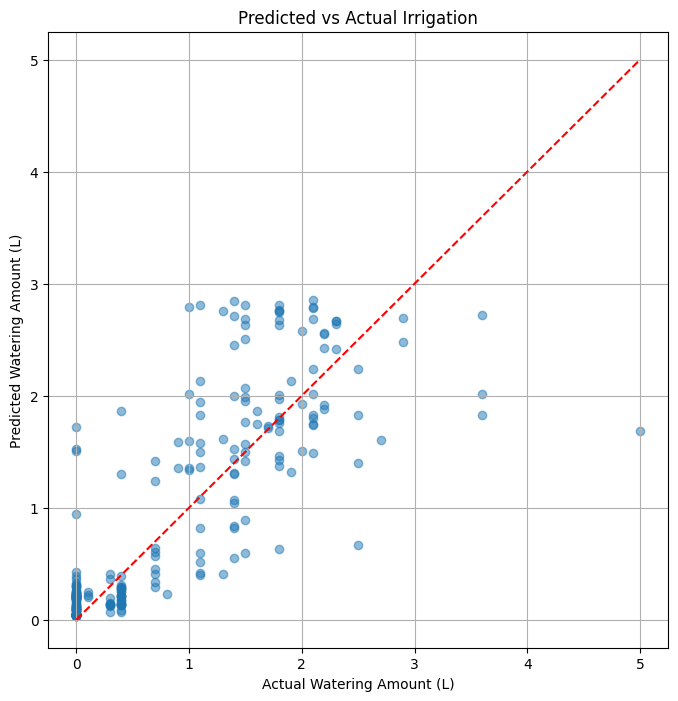

In [17]:
# Scatter plot of predicted vs. actual irrigation volumes for the test set. The red dashed line indicates perfect prediction.

plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--')  # Ideal line
plt.xlabel("Actual Watering Amount (L)")
plt.ylabel("Predicted Watering Amount (L)")
plt.title("Predicted vs Actual Irrigation")
plt.grid(True)
plt.show()


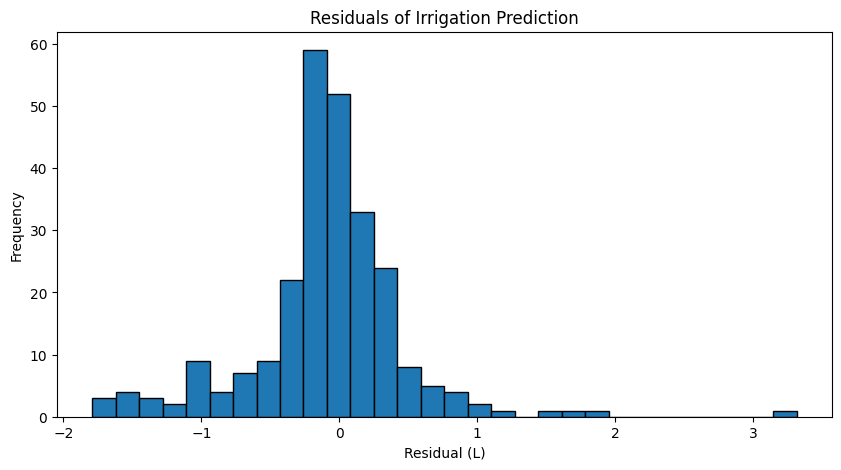

In [18]:
# Histogram of prediction residuals. Most predictions are close to zero error, indicating a good fit.

residuals = y_test - y_pred
plt.figure(figsize=(10,5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Residuals of Irrigation Prediction")
plt.xlabel("Residual (L)")
plt.ylabel("Frequency")
plt.show()


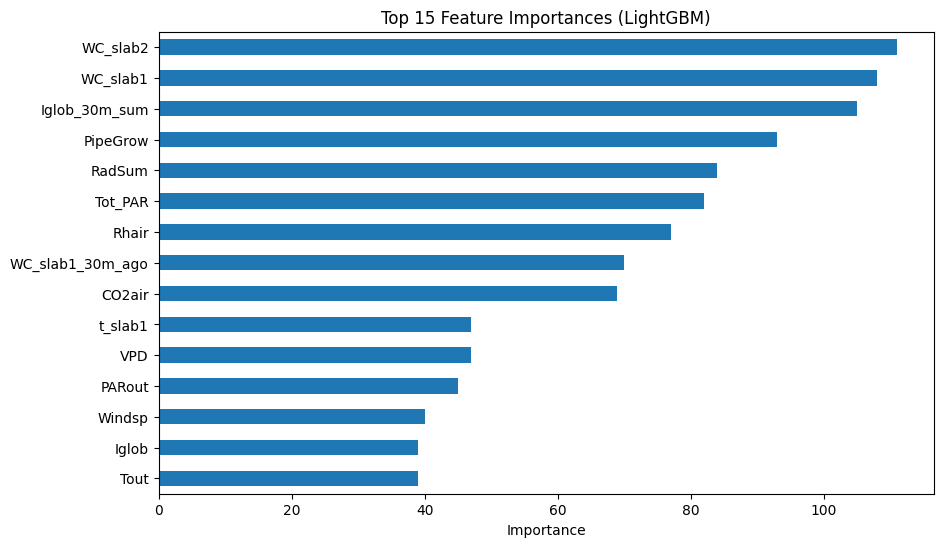

In [ ]:
# Top 15 features contributing to irrigation predictions.

import pandas as pd
import matplotlib.pyplot as plt

feat_importances = pd.Series(lgb_reg.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)[:15]  # Top 15
plt.figure(figsize=(10,6))
feat_importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (LightGBM)")
plt.xlabel("Importance")
plt.show()


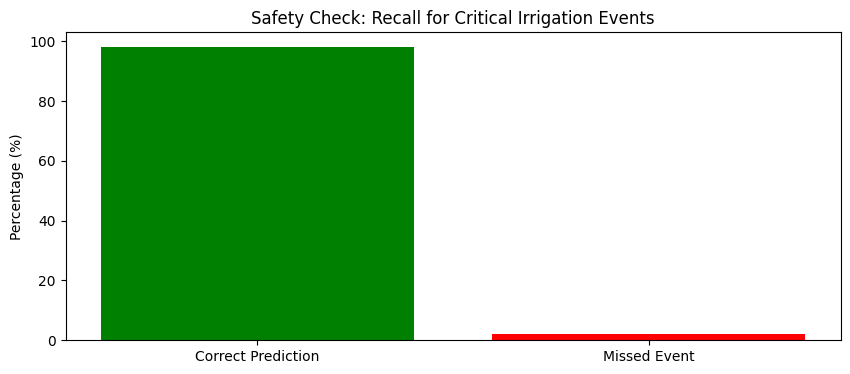

In [20]:
# Bar plot showing the model’s ability to detect critical irrigation needs (≥0.1 L) in the test set. Recall = 0.9805.

plt.figure(figsize=(10,4))
plt.bar(["Correct Prediction", "Missed Event"], [recall * 100, (1-recall)*100], color=['green','red'])
plt.ylabel("Percentage (%)")
plt.title("Safety Check: Recall for Critical Irrigation Events")
plt.show()


In [22]:
y_pred_series = pd.Series(y_pred, index=y_test.index)

extreme_threshold = 2.0  # liters
extreme_cases = y_test[y_test > extreme_threshold]
under_pred = y_pred_series[extreme_cases.index] < extreme_threshold

print(f"Number of extreme events: {len(extreme_cases)}")
print(f"Number under-predicted: {under_pred.sum()}")


Number of extreme events: 31
Number under-predicted: 13


In [15]:
import joblib

model_filename = 'irrigation_regressor.joblib' 

joblib.dump(lgb_reg, model_filename)

print(f"✅ Model saved to: {model_filename}")

✅ Model saved to: irrigation_regressor.joblib


In [16]:
import sys
import os
import joblib

print("\n===== MODEL WEIGHT CHECK =====")

# 1. CHECK STORAGE/RAM WEIGHT (Serialized Size)
temp_file = 'temp_model_check.joblib'
joblib.dump(lgb_reg, temp_file)
size_bytes = os.path.getsize(temp_file)
size_kb = size_bytes / 1024
os.remove(temp_file) # Clean up

print(f"💾 Physical Size: {size_kb:.2f} KB")
print(f"   (This is roughly how much Flash memory it might take)")

# 2. CHECK COMPUTATIONAL WEIGHT (Complexity)
booster = lgb_reg.booster_
num_trees = booster.num_trees()
print(f"🌳 Number of Trees: {num_trees}")

# Estimate C-Code size
# A rough rule of thumb: 1 Tree ~= 1.5 KB of C code source text
est_c_size = num_trees * 1.5
print(f"📝 Estimated C-Code Source Size: ~{est_c_size:.0f} KB")

if size_kb > 1000:
    print("⚠️ WARNING: Model is heavy (>1MB). Might need partition resizing on ESP32.")
else:
    print("✅ GREEN: Model is lightweight and safe for ESP32.")


===== MODEL WEIGHT CHECK =====
💾 Physical Size: 152.52 KB
   (This is roughly how much Flash memory it might take)
🌳 Number of Trees: 100
📝 Estimated C-Code Source Size: ~150 KB
✅ GREEN: Model is lightweight and safe for ESP32.
